# Timeseries - Boulder temperature measurements

In [2]:
# By line: RRB 2021-03-22
# Script aims to:
# - Load txt file
# - Calculate month averages from daily time resolution
# - Plot timeseries
# - Plot climatological seasonal cycles for a time range
# - Overplot years

### Load python packages

In [3]:
import pandas as pd
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata
import datetime
from pathlib import Path                   # System agnostic paths

### Create reusable functions

In [4]:
# Re-usable plotting call
def ts_plot(time_arr,val_arr,color_choice,label_string):
    plt.plot(time_arr, val_arr, '-ok', label=label_string,
         color=color_choice,
         markersize=8, linewidth=3,
         markerfacecolor=color_choice,
         markeredgecolor='grey',
         markeredgewidth=1)

In [5]:
# Month averages for the whole timeset
def cal_clim_month(pandas_DataArray):
    clim_cyc = pd.DataFrame(np.zeros((12, 2)),columns=['Clim_avg','Clim_sd'])
    num_obs = clim_cyc.shape[0]
    #calculate climatological month values
    for i in range(num_obs):
        clim_cyc['Clim_avg'][i] = np.nanmean(pandas_DataArray[pandas_DataArray.index.month == i+1])
        clim_cyc['Clim_sd'][i] = np.nanstd(pandas_DataArray[pandas_DataArray.index.month == i+1])
    clim_cyc.index = np.arange(1, 13, step=1)
    return clim_cyc

### Setup month array names

In [6]:
month_names = ['Jan','Feb','Mar','Apr','May','Jun',
              'Jul','Aug','Sep','Oct','Nov','Dec']

### Load measurements and create month averages

In [8]:
# From https://psl.noaa.gov/boulder/#climo
# Format: year, mon, day, tmax, tmin, precip, snow, snowcover
# units: degF for temperature; inches precip and snow
result_dir = Path("../../data/")
temp_file = 'boulderdaily.complete.txt'
data = pd.read_csv(str(result_dir/temp_file), header=None, skiprows=1, 
                 skipfooter=14, na_values=[-998.,-999.], delimiter = "\s+", 
                 names=['year', 'mon', 'day', 'tmax', 'tmin', 'precip', 'snow', 'snowcover'],
                 engine='python')
concat_date = data['year']*10000+data['mon']*100+data['day']
meas_date = pd.to_datetime(concat_date.astype(str),format='%Y%m%d', errors='coerce')
meas_var = data[['tmax','tmin']]
meas_var.index = meas_date

### Resample on monthly timescale

In [15]:
#can choose mean, max, min
meas_var_month = meas_var.resample('M',loffset=pd.Timedelta(-15, 'd')).mean()


### Plot the value versus time.

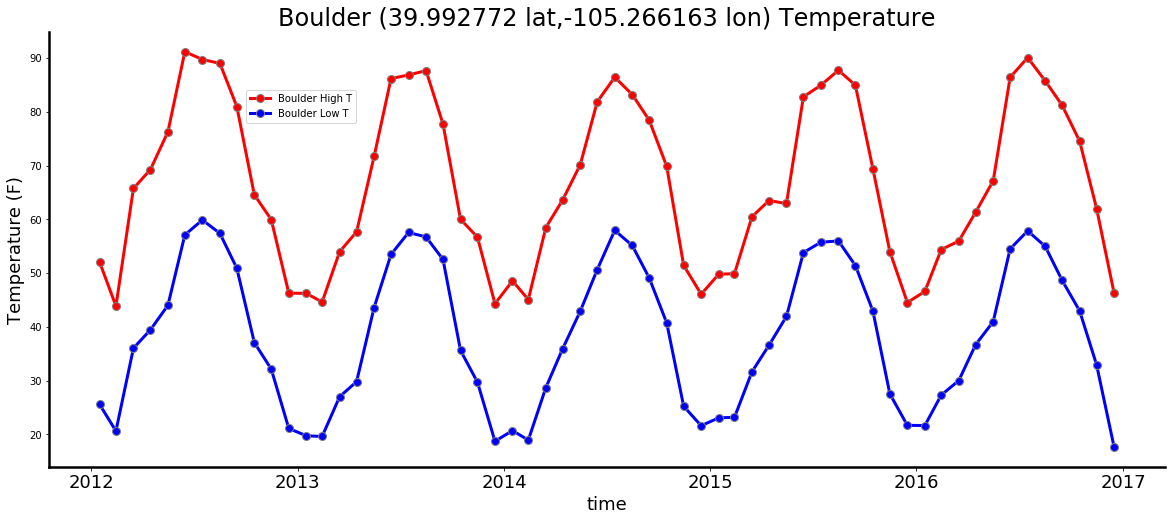

In [16]:
plt.figure(figsize=(20,8))
ax = plt.axes()

ts_plot(meas_var_month['2012':'2016'].index,meas_var_month['tmax']['2012':'2016'],'red','Boulder High T')
ts_plot(meas_var_month['2012':'2016'].index,meas_var_month['tmin']['2012':'2016'],'blue','Boulder Low T')


# axes format
plt.xticks(fontsize=18)
#ax.set_ylim(0, 0.4)
#plt.yticks(np.arange(0, 0.45, step=0.05), fontsize=18)

# adjust border
ax.spines["left"].set_linewidth(2.5)
ax.spines["bottom"].set_linewidth(2.5)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

#titles
plt.title('Boulder (39.992772 lat,-105.266163 lon) Temperature',fontsize=24)        
plt.xlabel('time',fontsize=18)
plt.ylabel('Temperature (F)',fontsize=18)

# legend
plt.legend(bbox_to_anchor=(0.28, 0.78),loc='lower right')

plt.show() 

### Seasonal Cycles

In [17]:
boulder_tmax_clim = cal_clim_month(meas_var_month['tmax']['2012':'2016'])
boulder_tmin_clim = cal_clim_month(meas_var_month['tmin']['2012':'2016'])

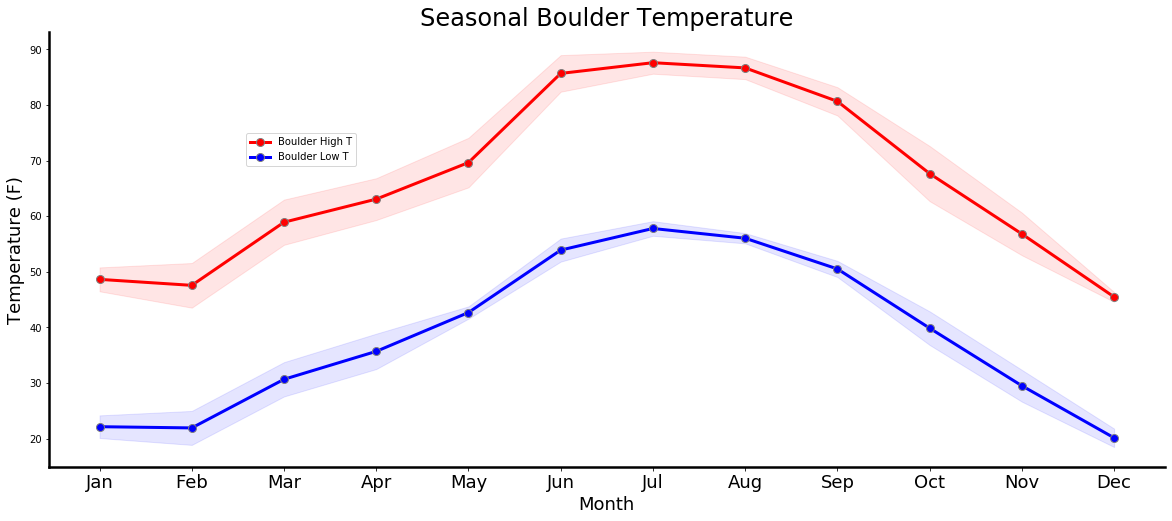

In [18]:
plt.figure(figsize=(20,8))
ax = plt.axes()

ts_plot(month_names,boulder_tmax_clim['Clim_avg'],'red','Boulder High T')
plt.fill_between(month_names,boulder_tmax_clim['Clim_avg'] - boulder_tmax_clim['Clim_sd'],
                 boulder_tmax_clim['Clim_avg'] + boulder_tmax_clim['Clim_sd'],
                 color='red', alpha=0.1)

ts_plot(month_names,boulder_tmin_clim['Clim_avg'],'blue','Boulder Low T')
plt.fill_between(month_names,boulder_tmin_clim['Clim_avg'] - boulder_tmin_clim['Clim_sd'],
                 boulder_tmin_clim['Clim_avg'] + boulder_tmin_clim['Clim_sd'],
                 color='blue', alpha=0.1)


# axes format
plt.xticks(fontsize=18)
#ax.set_ylim(0, 0.25)
#plt.yticks(np.arange(0, 0.30, step=0.05), fontsize=18)

# adjust border
ax.spines["left"].set_linewidth(2.5)
ax.spines["bottom"].set_linewidth(2.5)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

#titles
plt.title('Seasonal Boulder Temperature',fontsize=24)        
plt.xlabel('Month',fontsize=18)
plt.ylabel('Temperature (F)',fontsize=18)

# legend
plt.legend(bbox_to_anchor=(0.28, 0.68),loc='lower right')

plt.show() 

### Overplot years for tmax
Create year arrays

In [19]:
startyear = 1920
year_array = np.arange(startyear, 2020, step=1)
year_str = year_array.astype(str)
num_year = year_array.shape[0]

Do the plotting

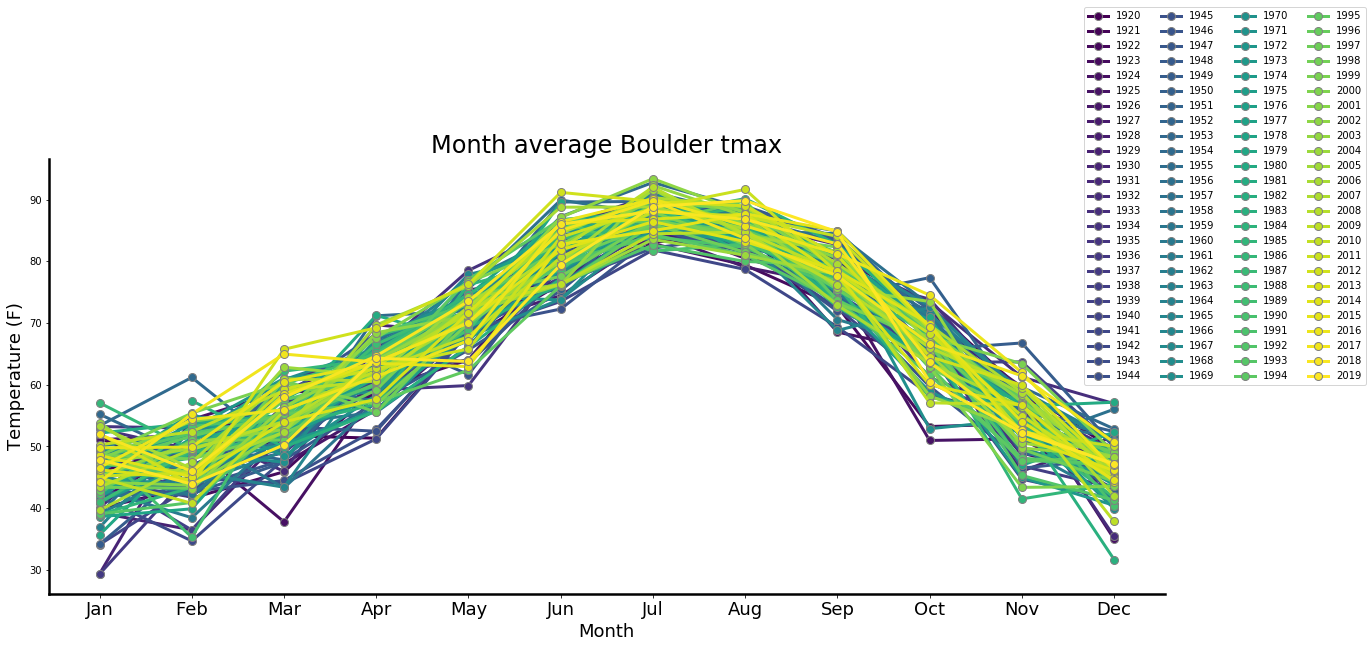

In [22]:
plt.figure(figsize=(20,8))
ax = plt.axes()

# Different colors for different lines
# colormaps at https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html
colormap = plt.cm.viridis
colors = [colormap(i) for i in np.linspace(0, 1,num_year)]

for y in year_array:
    plt.plot(month_names, meas_var_month['tmax'][str(y)], '-ok', label=year_str[y-startyear],
             color=colors[y-startyear], markerfacecolor=colors[y-startyear], markersize=8,
             linewidth=3, markeredgecolor='grey',
             markeredgewidth=1)

# axes format
plt.xticks(fontsize=18)
#ax.set_ylim(0, 0.35)
#plt.yticks(np.arange(0, 0.40, step=0.05), fontsize=18)

# adjust border
ax.spines["left"].set_linewidth(2.5)
ax.spines["bottom"].set_linewidth(2.5)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

#titles
plt.title('Month average Boulder tmax',fontsize=24)        
plt.xlabel('Month',fontsize=18)
plt.ylabel('Temperature (F)',fontsize=18)

# legend
plt.legend(bbox_to_anchor=(1.18, 0.48),loc='lower right', borderaxespad=0., ncol=4)

plt.show() 